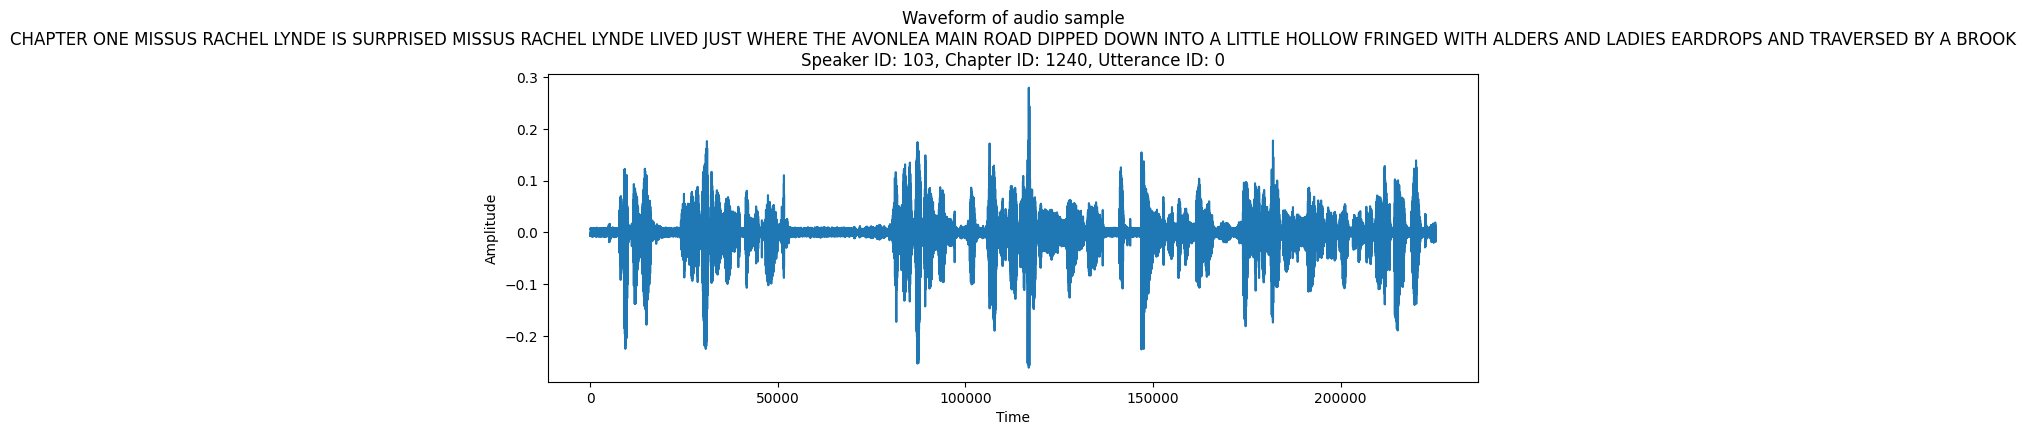

Picked device: cpu


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted Text for /kaggle/input/librispeech/LibriSpeech/dev-clean/174/50561/174-50561-0002.wav: but this is a fallacy but this is a fallacy but this is a fallacy ut this is a fallacy but this is a fallacy but this is a fallacy but this is a fallacy ut this is a fallacy but this is a fallacy


Processing Dataset: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

Successfully saved results to /kaggle/working/results.csv

CSV Content:
Audio ID,Expected Text,Predicted Text
1089-134686-0,he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce,he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flower fat and sauce
1089-134686-1,stuff it into you his belly counselled him,stuffered into you his belly counselled him



In [7]:
# Install required packages (uncomment if running in a fresh environment)
# !pip install torch torchaudio transformers tqdm numpy matplotlib IPython

import torchaudio
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import csv
from pathlib import Path
import string
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

# Dataset
root_path = '/kaggle/input/librispeech-clean'
train_dataset = torchaudio.datasets.LIBRISPEECH(root_path, url="train-clean-100", download=False)
test_dataset = torchaudio.datasets.LIBRISPEECH(root_path, url="test-clean", download=False)

# Visualize waveform (optional)
waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = train_dataset[0]
plt.figure(figsize=(12, 4))
plt.plot(waveform.t().numpy())
plt.title(f"Waveform of audio sample\n{utterance}\nSpeaker ID: {speaker_id}, Chapter ID: {chapter_id}, Utterance ID: {utterance_id}")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()
ipd.Audio(waveform.numpy(), rate=sample_rate)

# Utility functions
def levenshtein_distance(ref, hyp):
    """Calculate the Levenshtein distance between two sequences."""
    m, n = len(ref), len(hyp)
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m
    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m
    previous_row = range(n + 1)
    for i, c1 in enumerate(ref):
        current_row = [i + 1]
        for j, c2 in enumerate(hyp):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

def normalize_text(text, ignore_case=False, remove_space=False):
    """Normalize text based on specified conditions."""
    if ignore_case:
        text = text.lower()
    if remove_space:
        text = ''.join(text.split())
    return text

def wer(reference, hypothesis, ignore_case=False):
    """Calculate Word Error Rate with proper tokenization."""
    reference = normalize_text(reference, ignore_case, False)
    hypothesis = normalize_text(hypothesis, ignore_case, False)
    ref_words = reference.split()
    hyp_words = hypothesis.split()
    edit_distance = levenshtein_distance(ref_words, hyp_words)
    ref_len = len(ref_words)
    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")
    return edit_distance / ref_len

def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """Calculate Character Error Rate."""
    reference = normalize_text(reference, ignore_case, remove_space)
    hypothesis = normalize_text(hypothesis, ignore_case, remove_space)
    edit_distance = levenshtein_distance(reference, hypothesis)
    ref_len = len(reference)
    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")
    return edit_distance / ref_len

# Text Transform
class TextTransform:
    """Maps characters to integers and vice versa."""
    def __init__(self):  # Fixed typo: _init_ -> __init__
        additional_chars = ["''", '<SPACE>']
        all_chars = additional_chars + list(string.ascii_lowercase)
        self.char_map = {char: i for i, char in enumerate(all_chars)}
        self.index_map = {index: char for char, index in self.char_map.items()}
        self.index_map[self.char_map['<SPACE>']] = ' '

    def text_to_int(self, text):
        """Convert text to an integer sequence."""
        return [self.char_map.get(c, self.char_map['<SPACE>']) for c in text.lower()]

    def int_to_text(self, labels):
        """Convert integer labels to a text sequence."""
        return ''.join(self.index_map[i] for i in labels).replace('<SPACE>', ' ')

text_transform = TextTransform()

# Audio Transforms
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)
valid_audio_transforms = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128)

# Data Processing
def data_processing(data, data_type='train'):
    """Process data for training or validation."""
    if data_type not in ['train', 'valid']:
        raise ValueError("data_type should be either 'train' or 'valid'")
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    audio_transforms = train_audio_transforms if data_type == 'train' else valid_audio_transforms
    for (waveform, _, utterance, _, _, _) in data:
        spec = audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0] // 2)
        label_lengths.append(len(label))
    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)
    return spectrograms, labels, input_lengths, label_lengths

# Data Loaders
pipeline_params = {
    'batch_size': 10,
    'epochs': 10,
    'learning_rate': 5e-4,
    'n_cnn_layers': 3,
    'n_rnn_layers': 5,
    'rnn_dim': 512,
    'n_class': 29,
    'n_feats': 128,
    'stride': 2,
    'dropout': 0.1
}
kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=pipeline_params['batch_size'],
                                           shuffle=True,
                                           collate_fn=lambda x: data_processing(x, 'train'),
                                           **kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=pipeline_params['batch_size'],
                                          shuffle=True,
                                          collate_fn=lambda x: data_processing(x, 'valid'),
                                          **kwargs)

# Device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Picked device:", device)

# Load Pre-trained Wav2Vec 2.0 Model
model_name = "facebook/wav2vec2-base-960h"
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2ForCTC.from_pretrained(model_name).to(device)
model.eval()

# Greedy Decoder
def greedy_decoder(output_probs, blank_label=None):
    """Decode Wav2Vec 2.0 output logits to text."""
    predicted_ids = torch.argmax(output_probs, dim=-1)
    transcription = processor.batch_decode(predicted_ids)
    return transcription

# Speech-to-Text Function
def speech_to_text(audio_path, model, device, processor):
    """Convert an audio file to text using pre-trained Wav2Vec 2.0."""
    model.eval()
    waveform, sample_rate = torchaudio.load(audio_path)
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(sample_rate, 16000)
        waveform = resampler(waveform)
    input_values = processor(waveform.squeeze(0), sampling_rate=16000, return_tensors="pt").input_values
    input_values = input_values.to(device)
    with torch.no_grad():
        logits = model(input_values).logits
        predicted_text = greedy_decoder(logits)[0]
    return predicted_text.lower()

# Validation Function (optional, kept for completeness)
def validate(model, validation_loader, criterion, device):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        all_predicted_texts = []
        all_true_texts = []
        for batch_idx, _data in tqdm(enumerate(validation_loader), total=len(validation_loader),
                                     desc="Validating"):
            spectrograms, labels, input_lengths, label_lengths = _data
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            output = model(spectrograms).logits
            output_log_softmax = F.log_softmax(output, dim=2)
            output_for_loss = output_log_softmax.transpose(0, 1)
            loss = criterion(output_for_loss, labels, input_lengths, label_lengths)
            total_loss += loss.item()
            decoded_outputs = greedy_decoder(output_log_softmax)
            predicted_texts = [text.lower() for text in decoded_outputs]
            true_texts = [text_transform.int_to_text(labels[i, :label_lengths[i]].tolist())
                          for i in range(labels.size(0))]
            all_predicted_texts.extend(predicted_texts)
            all_true_texts.extend(true_texts)
        avg_loss = total_loss / len(validation_loader)
        avg_wer = np.mean([wer(ref, hyp) for ref, hyp in zip(all_true_texts, all_predicted_texts)])
        avg_cer = np.mean([cer(ref, hyp) for ref, hyp in zip(all_true_texts, all_predicted_texts)])
        print(f"Validation Loss: {avg_loss:.6f}")
        print(f"Average WER: {avg_wer:.4f}")
        print(f"Average CER: {avg_cer:.4f}")

# Generate Results CSV from Dataset
def generate_results_csv_from_dataset(dataset, model, device, processor, output_path="/kaggle/working/results.csv", max_samples=2):
    model.eval()
    results = []
    Path(output_path).parent.mkdir(parents=True, exist_ok=True)
    
    for i in tqdm(range(min(max_samples, len(dataset))), desc="Processing Dataset"):
        try:
            waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = dataset[i]
            audio_id = f"{speaker_id}-{chapter_id}-{utterance_id}"
            expected_text = utterance.lower()
            
            # Save waveform to a temporary file
            temp_audio_path = f"/kaggle/working/temp_{audio_id}.wav"
            torchaudio.save(temp_audio_path, waveform, sample_rate)
            
            predicted_text = speech_to_text(temp_audio_path, model, device, processor)
            results.append([audio_id, expected_text, predicted_text])
            
            # Clean up temporary file
            Path(temp_audio_path).unlink(missing_ok=True)
        except Exception as e:
            print(f"Error processing sample {i}: {str(e)}")
            continue
    
    try:
        with open(output_path, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(["Audio ID", "Expected Text", "Predicted Text"])
            writer.writerows(results)
        print(f"Successfully saved results to {output_path}")
        
        # Print CSV content
        with open(output_path, 'r', encoding='utf-8') as f:
            print("\nCSV Content:")
            print(f.read())
    except Exception as e:
        print(f"Failed to write CSV: {str(e)}")

# Example Usage
audio_path = '/kaggle/input/librispeech/LibriSpeech/dev-clean/174/50561/174-50561-0002.wav'
predicted_text = speech_to_text(audio_path, model, device, processor)
print(f"Predicted Text for {audio_path}: {predicted_text}")

# Generate CSV with test dataset (first 2 samples)
generate_results_csv_from_dataset(test_dataset, model, device, processor, max_samples=2)

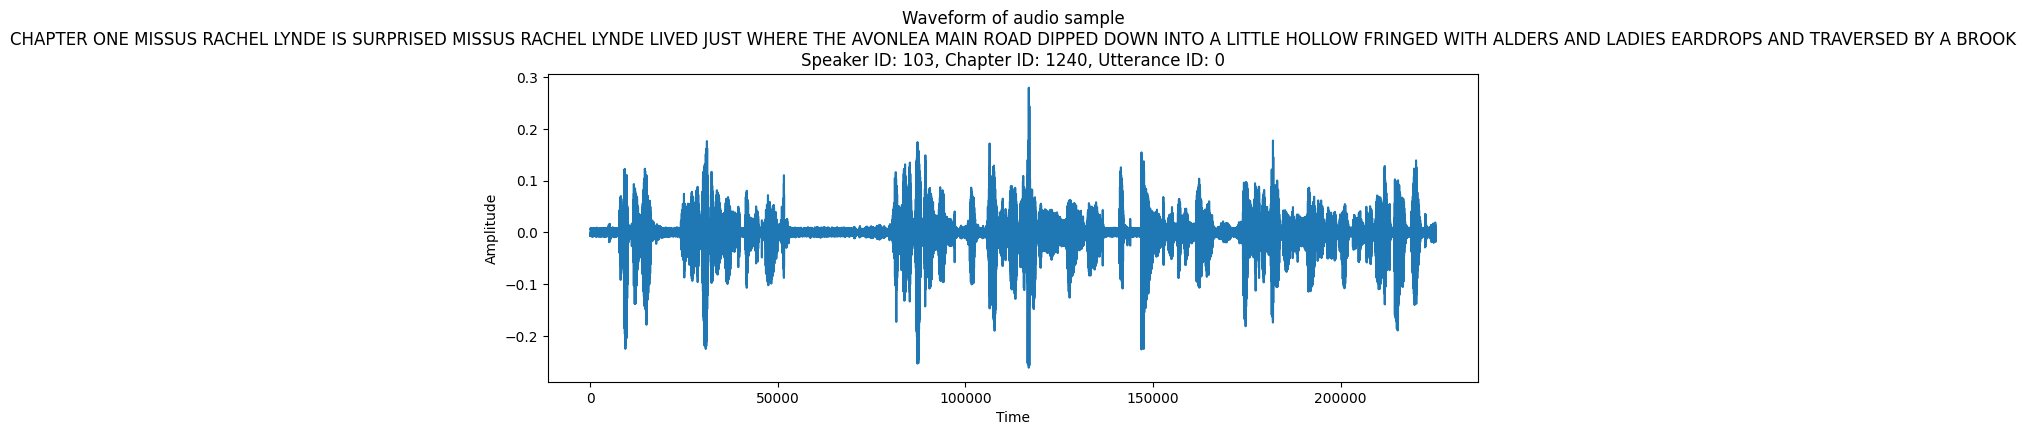

Picked device: cpu


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted Text for /kaggle/input/librispeech/LibriSpeech/dev-clean/174/50561/174-50561-0002.wav: but this is a fallacy but this is a fallacy but this is a fallacy ut this is a fallacy but this is a fallacy but this is a fallacy but this is a fallacy ut this is a fallacy but this is a fallacy


Processing Dataset: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

Successfully saved results to /kaggle/working/results.csv

CSV Content:
Audio ID,Expected Text,Predicted Text
1089-134686-0,he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce,he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flower fat and sauce
1089-134686-1,stuff it into you his belly counselled him,stuffered into you his belly counselled him
1089-134686-2,after early nightfall the yellow lamps would light up here and there the squalid quarter of the brothels,after early nightfall the yellow lamps would light up here and there the squalid quarter of the brothels
1089-134686-3,hello bertie any good in your mind,ho bertie any good in your mind
1089-134686-4,number ten fresh nelly is waiting on you good night husband,number ten fresh nelly is waiting on you good night husband



In [8]:
# Install required packages (uncomment if needed)
# !pip install torch torchaudio transformers tqdm numpy matplotlib IPython

import torchaudio
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import csv
from pathlib import Path
import string
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

# Dataset
root_path = '/kaggle/input/librispeech-clean'
train_dataset = torchaudio.datasets.LIBRISPEECH(root_path, url="train-clean-100", download=False)
test_dataset = torchaudio.datasets.LIBRISPEECH(root_path, url="test-clean", download=False)

# Visualize waveform (optional)
waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = train_dataset[0]
plt.figure(figsize=(12, 4))
plt.plot(waveform.t().numpy())
plt.title(f"Waveform of audio sample\n{utterance}\nSpeaker ID: {speaker_id}, Chapter ID: {chapter_id}, Utterance ID: {utterance_id}")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()
ipd.Audio(waveform.numpy(), rate=sample_rate)

# Utility functions
def levenshtein_distance(ref, hyp):
    m, n = len(ref), len(hyp)
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m
    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m
    previous_row = range(n + 1)
    for i, c1 in enumerate(ref):
        current_row = [i + 1]
        for j, c2 in enumerate(hyp):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

def normalize_text(text, ignore_case=False, remove_space=False):
    if ignore_case:
        text = text.lower()
    if remove_space:
        text = ''.join(text.split())
    return text

def wer(reference, hypothesis, ignore_case=False):
    reference = normalize_text(reference, ignore_case, False)
    hypothesis = normalize_text(hypothesis, ignore_case, False)
    ref_words = reference.split()
    hyp_words = hypothesis.split()
    edit_distance = levenshtein_distance(ref_words, hyp_words)
    ref_len = len(ref_words)
    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")
    return edit_distance / ref_len

def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    reference = normalize_text(reference, ignore_case, remove_space)
    hypothesis = normalize_text(hypothesis, ignore_case, remove_space)
    edit_distance = levenshtein_distance(reference, hypothesis)
    ref_len = len(reference)
    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")
    return edit_distance / ref_len

# Text Transform
class TextTransform:
    def __init__(self):
        additional_chars = ["''", '<SPACE>']
        all_chars = additional_chars + list(string.ascii_lowercase)
        self.char_map = {char: i for i, char in enumerate(all_chars)}
        self.index_map = {index: char for char, index in self.char_map.items()}
        self.index_map[self.char_map['<SPACE>']] = ' '

    def text_to_int(self, text):
        return [self.char_map.get(c, self.char_map['<SPACE>']) for c in text.lower()]

    def int_to_text(self, labels):
        return ''.join(self.index_map[i] for i in labels).replace('<SPACE>', ' ')

text_transform = TextTransform()

# Audio Transforms
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)
valid_audio_transforms = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128)

# Data Processing
def data_processing(data, data_type='train'):
    if data_type not in ['train', 'valid']:
        raise ValueError("data_type should be either 'train' or 'valid'")
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    audio_transforms = train_audio_transforms if data_type == 'train' else valid_audio_transforms
    for (waveform, _, utterance, _, _, _) in data:
        spec = audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0] // 2)
        label_lengths.append(len(label))
    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)
    return spectrograms, labels, input_lengths, label_lengths

# Data Loaders
pipeline_params = {
    'batch_size': 10,
    'epochs': 10,
    'learning_rate': 5e-4,
    'n_cnn_layers': 3,
    'n_rnn_layers': 5,
    'rnn_dim': 512,
    'n_class': 29,
    'n_feats': 128,
    'stride': 2,
    'dropout': 0.1
}
kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=pipeline_params['batch_size'],
                                           shuffle=True,
                                           collate_fn=lambda x: data_processing(x, 'train'),
                                           **kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=pipeline_params['batch_size'],
                                          shuffle=True,
                                          collate_fn=lambda x: data_processing(x, 'valid'),
                                          **kwargs)

# Device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Picked device:", device)

# Load Pre-trained Wav2Vec 2.0 Model
model_name = "facebook/wav2vec2-base-960h"
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2ForCTC.from_pretrained(model_name).to(device)
model.eval()

# Greedy Decoder
def greedy_decoder(output_probs, blank_label=None):
    predicted_ids = torch.argmax(output_probs, dim=-1)
    transcription = processor.batch_decode(predicted_ids)
    return transcription

# Speech-to-Text Function
def speech_to_text(audio_path, model, device, processor):
    model.eval()
    waveform, sample_rate = torchaudio.load(audio_path)
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(sample_rate, 16000)
        waveform = resampler(waveform)
    input_values = processor(waveform.squeeze(0), sampling_rate=16000, return_tensors="pt").input_values
    input_values = input_values.to(device)
    with torch.no_grad():
        logits = model(input_values).logits
        predicted_text = greedy_decoder(logits)[0]
    return predicted_text.lower()

# Validation Function (optional)
def validate(model, validation_loader, criterion, device):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        all_predicted_texts = []
        all_true_texts = []
        for batch_idx, _data in tqdm(enumerate(validation_loader), total=len(validation_loader),
                                     desc="Validating"):
            spectrograms, labels, input_lengths, label_lengths = _data
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            output = model(spectrograms).logits
            output_log_softmax = F.log_softmax(output, dim=2)
            output_for_loss = output_log_softmax.transpose(0, 1)
            loss = criterion(output_for_loss, labels, input_lengths, label_lengths)
            total_loss += loss.item()
            decoded_outputs = greedy_decoder(output_log_softmax)
            predicted_texts = [text.lower() for text in decoded_outputs]
            true_texts = [text_transform.int_to_text(labels[i, :label_lengths[i]].tolist())
                          for i in range(labels.size(0))]
            all_predicted_texts.extend(predicted_texts)
            all_true_texts.extend(true_texts)
        avg_loss = total_loss / len(validation_loader)
        avg_wer = np.mean([wer(ref, hyp) for ref, hyp in zip(all_true_texts, all_predicted_texts)])
        avg_cer = np.mean([cer(ref, hyp) for ref, hyp in zip(all_true_texts, all_predicted_texts)])
        print(f"Validation Loss: {avg_loss:.6f}")
        print(f"Average WER: {avg_wer:.4f}")
        print(f"Average CER: {avg_cer:.4f}")

# Generate Results CSV from Dataset
def generate_results_csv_from_dataset(dataset, model, device, processor, output_path="/kaggle/working/results.csv", max_samples=5):
    model.eval()
    results = []
    Path(output_path).parent.mkdir(parents=True, exist_ok=True)
    
    for i in tqdm(range(min(max_samples, len(dataset))), desc="Processing Dataset"):
        try:
            waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = dataset[i]
            audio_id = f"{speaker_id}-{chapter_id}-{utterance_id}"
            expected_text = utterance.lower()
            
            temp_audio_path = f"/kaggle/working/temp_{audio_id}.wav"
            torchaudio.save(temp_audio_path, waveform, sample_rate)
            
            predicted_text = speech_to_text(temp_audio_path, model, device, processor)
            results.append([audio_id, expected_text, predicted_text])
            
            Path(temp_audio_path).unlink(missing_ok=True)
        except Exception as e:
            print(f"Error processing sample {i}: {str(e)}")
            continue
    
    try:
        with open(output_path, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(["Audio ID", "Expected Text", "Predicted Text"])
            writer.writerows(results)
        print(f"Successfully saved results to {output_path}")
        
        with open(output_path, 'r', encoding='utf-8') as f:
            print("\nCSV Content:")
            print(f.read())
    except Exception as e:
        print(f"Failed to write CSV: {str(e)}")

# Example Usage
audio_path = '/kaggle/input/librispeech/LibriSpeech/dev-clean/174/50561/174-50561-0002.wav'
predicted_text = speech_to_text(audio_path, model, device, processor)
print(f"Predicted Text for {audio_path}: {predicted_text}")

# Generate CSV with 5 samples
generate_results_csv_from_dataset(test_dataset, model, device, processor, max_samples=5)

In [9]:
import torchaudio
import numpy as np
import torch
from tqdm import tqdm
import csv
from pathlib import Path
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

# Dataset
root_path = '/kaggle/input/librispeech-clean'
test_dataset = torchaudio.datasets.LIBRISPEECH(root_path, url="test-clean", download=False)

# Utility functions
def levenshtein_distance(ref, hyp):
    m, n = len(ref), len(hyp)
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m
    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m
    previous_row = range(n + 1)
    for i, c1 in enumerate(ref):
        current_row = [i + 1]
        for j, c2 in enumerate(hyp):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

def normalize_text(text, ignore_case=False, remove_space=False):
    if ignore_case:
        text = text.lower()
    if remove_space:
        text = ''.join(text.split())
    return text

def wer(reference, hypothesis, ignore_case=False):
    reference = normalize_text(reference, ignore_case, False)
    hypothesis = normalize_text(hypothesis, ignore_case, False)
    ref_words = reference.split()
    hyp_words = hypothesis.split()
    edit_distance = levenshtein_distance(ref_words, hyp_words)
    ref_len = len(ref_words)
    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")
    return edit_distance / ref_len

def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    reference = normalize_text(reference, ignore_case, remove_space)
    hypothesis = normalize_text(hypothesis, ignore_case, remove_space)
    edit_distance = levenshtein_distance(reference, hypothesis)
    ref_len = len(reference)
    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")
    return edit_distance / ref_len

# Device
device = torch.device("cpu")  # Using CPU as per your previous output
print("Picked device:", device)

# Load Pre-trained Wav2Vec 2.0 Model
model_name = "facebook/wav2vec2-base-960h"
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2ForCTC.from_pretrained(model_name).to(device)
model.eval()

# Speech-to-Text Function
def speech_to_text(audio_path, model, device, processor):
    model.eval()
    waveform, sample_rate = torchaudio.load(audio_path)
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(sample_rate, 16000)
        waveform = resampler(waveform)
    input_values = processor(waveform.squeeze(0), sampling_rate=16000, return_tensors="pt").input_values
    input_values = input_values.to(device)
    with torch.no_grad():
        logits = model(input_values).logits
        predicted_ids = torch.argmax(logits, dim=-1)
        predicted_text = processor.batch_decode(predicted_ids)[0]
    return predicted_text.lower()

# Generate Results CSV with Overall WER and CER
def generate_results_csv_from_dataset(dataset, model, device, processor, output_path="/kaggle/working/results.csv", max_samples=262):
    model.eval()
    results = []
    expected_texts = []
    predicted_texts = []
    Path(output_path).parent.mkdir(parents=True, exist_ok=True)
    
    for i in tqdm(range(min(max_samples, len(dataset))), desc="Processing Dataset"):
        try:
            waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = dataset[i]
            audio_id = f"{speaker_id}-{chapter_id}-{utterance_id}"
            expected_text = utterance.lower()
            
            temp_audio_path = f"/kaggle/working/temp_{audio_id}.wav"
            torchaudio.save(temp_audio_path, waveform, sample_rate)
            
            predicted_text = speech_to_text(temp_audio_path, model, device, processor)
            
            results.append([audio_id, expected_text, predicted_text])
            expected_texts.append(expected_text)
            predicted_texts.append(predicted_text)
            
            Path(temp_audio_path).unlink(missing_ok=True)
        except Exception as e:
            print(f"Error processing sample {i}: {str(e)}")
            continue
    
    # Calculate overall WER and CER
    overall_wer = np.mean([wer(ref, hyp) for ref, hyp in zip(expected_texts, predicted_texts)]) if expected_texts else 0.0
    overall_cer = np.mean([cer(ref, hyp) for ref, hyp in zip(expected_texts, predicted_texts)]) if expected_texts else 0.0
    
    try:
        with open(output_path, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(["Audio ID", "Expected Text", "Predicted Text"])
            writer.writerows(results)
            writer.writerow(["Overall", "", "", overall_wer, overall_cer])
        print(f"Successfully saved results to {output_path}")
        
        # Print a preview of CSV content (first 5 and last 5 rows, including overall)
        with open(output_path, 'r', encoding='utf-8') as f:
            lines = f.read().splitlines()
            print("\nCSV Content Preview (first 5 rows and last 5 rows including overall):")
            if len(lines) <= 11:  # If fewer than 11 lines, print all
                print('\n'.join(lines))
            else:
                print('\n'.join(lines[:6] + lines[-5:]))  # Header + 5 rows, last 4 rows + overall
        print(f"\nOverall WER: {overall_wer:.4f}")
        print(f"Overall CER: {overall_cer:.4f}")
    except Exception as e:
        print(f"Failed to write CSV: {str(e)}")

# Example Usage
audio_path = '/kaggle/input/librispeech/LibriSpeech/dev-clean/174/50561/174-50561-0002.wav'
predicted_text = speech_to_text(audio_path, model, device, processor)
print(f"Predicted Text for {audio_path}: {predicted_text}")

# Generate CSV with 262 samples
generate_results_csv_from_dataset(test_dataset, model, device, processor, max_samples=262)

Picked device: cpu


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted Text for /kaggle/input/librispeech/LibriSpeech/dev-clean/174/50561/174-50561-0002.wav: but this is a fallacy but this is a fallacy but this is a fallacy ut this is a fallacy but this is a fallacy but this is a fallacy but this is a fallacy ut this is a fallacy but this is a fallacy


Processing Dataset: 100%|██████████| 262/262 [05:43<00:00,  1.31s/it]


Successfully saved results to /kaggle/working/results.csv

CSV Content Preview (first 5 rows and last 5 rows including overall):
Audio ID,Expected Text,Predicted Text
1089-134686-0,he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce,he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flower fat and sauce
1089-134686-1,stuff it into you his belly counselled him,stuffered into you his belly counselled him
1089-134686-2,after early nightfall the yellow lamps would light up here and there the squalid quarter of the brothels,after early nightfall the yellow lamps would light up here and there the squalid quarter of the brothels
1089-134686-3,hello bertie any good in your mind,ho bertie any good in your mind
1089-134686-4,number ten fresh nelly is waiting on you good night husband,number ten fresh nell